In [28]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import allel

import  umap
import umap.plot

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

%matplotlib inline

In [2]:
sns.set(style='ticks', context='notebook', rc={'figure.figsize':(9,7)})

## UMAP

In [3]:
chr7_females = allel.read_vcf('../steps/recode_vcf/chr7_females.recode.vcf')

In [4]:
meta_data_samples = pd.read_table("../data/metadata_erik.txt", sep=" ")

In [5]:
meta_data_females = meta_data_samples[meta_data_samples['Sex'] == 'F']

In [6]:
def vcf2df(vcf):
    gt = allel.GenotypeArray(vcf['calldata/GT'])
    ac = gt.count_alleles()
    
    # Filter away singletons and multiallelic SNPs
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = gt.compress(flt, axis=0)
    
    # Final df
    gn = gf.to_n_alt()
    
    return gn

In [7]:
def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [30]:
def perform_umap(df, pop):
    
    scaled_df = StandardScaler().fit_transform(df)
    
    reducer = umap.UMAP()
    
    embedding = reducer.fit_transform(scaled_df.T)
    
    umap_df = pd.DataFrame(data = embedding,
                       columns = ['1', '2'])
    
    pop = pop.reset_index(drop = True)
    
    final_df = pd.concat([umap_df, pop['C_origin']], axis = 1)
    
    return final_df

In [9]:
def plot_umap(df):
    fig, ax = plt.subplots(figsize = (9,5))

    groups = df.groupby('C_origin')
    for name, group in groups:
        ax.scatter(group['1'], group['2'], label=name)
    
    ax.set_title('UMAP projection', fontsize = 15)
    ax.legend(bbox_to_anchor=(1.1, 1))
    
    fig.tight_layout()
    plt.show()

In [10]:
df = vcf2df(chr7_females)

In [11]:
pruned_df = ld_prune(df, size=500, step=200, threshold=.1, n_iter=5)

iteration 1 retaining 202449 removing 2747182 variants
iteration 2 retaining 26398 removing 176051 variants
iteration 3 retaining 7602 removing 18796 variants
iteration 4 retaining 4267 removing 3335 variants
iteration 5 retaining 3452 removing 815 variants


In [31]:
chr7_females_umap = perform_umap(pruned_df, meta_data_females)

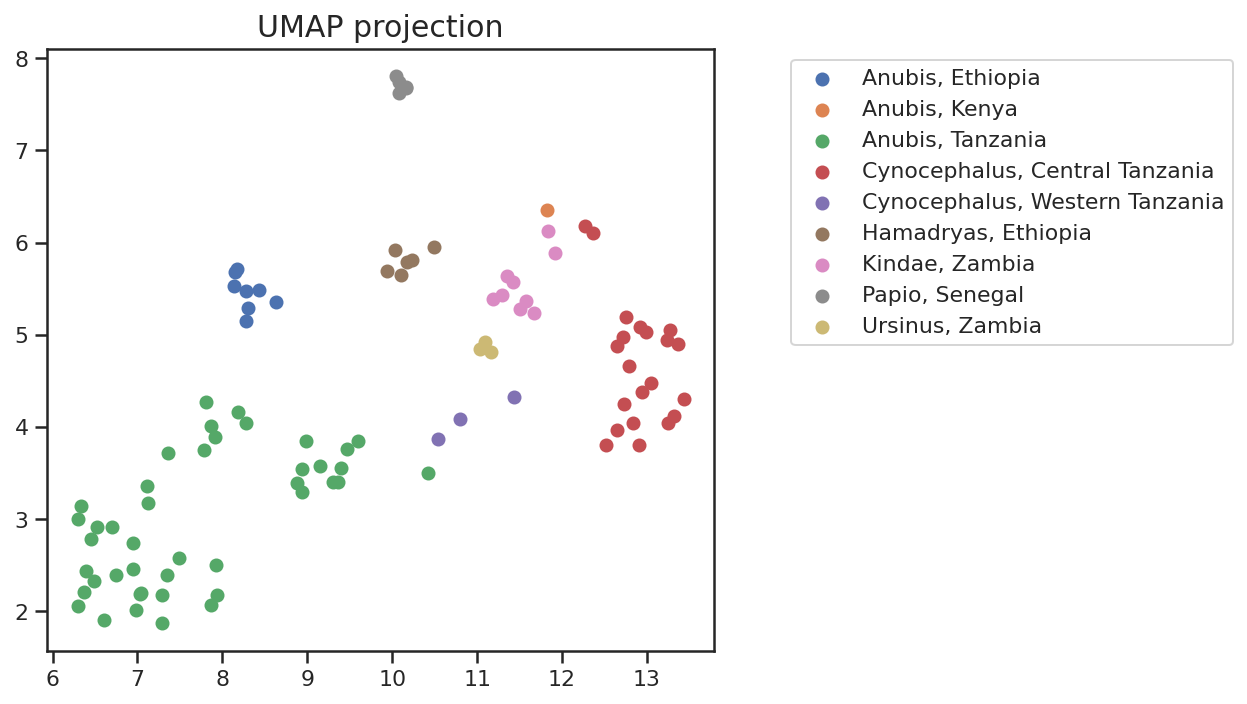

In [32]:
plot_umap(chr7_females_umap)

In [33]:
umap.plot.points(chr7_females_umap)

ValueError: Could not find embedding attribute of umap_object

In [16]:
umap.plot.diagnostic(chr7_females_umap, diagnostic_type='pca')

ValueError: Could not find embedding attribute of umap_object

In [ ]:
umap.plot.diagnostic(chr7_females_umap, diagnostic_type='vq')

In [ ]:
local_dims = umap.plot.diagnostic(chr7_females_umap, diagnostic_type='local_dim')

In [ ]:
umap.plot.diagnostic(chr7_females_umap, diagnostic_type='neighborhood')